# HW05: Deep Learning

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

In [1]:
#Import the AG news dataset (same as hw01)
#Download them from here 
#!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df = df.sample(n=10000) # # only use 10K datapoints
df.head()

,label,title,lead,text
1794,world,Public servant backs Scrafton,PRIME Minister John Howard said he would not b...,Public servant backs Scrafton PRIME Minister J...
104943,world,Iran Says Nuclear Freeze Talks Must Not Last Long,TEHRAN (Reuters) - Iran reiterated Tuesday it...,Iran Says Nuclear Freeze Talks Must Not Last L...
89524,sport,Confident Mourinho Plans Early End to Title Race,LONDON (Reuters) - Chelsea manager Jose Mouri...,Confident Mourinho Plans Early End to Title Ra...
92522,world,Beach Boy Brian Wilson Has Reason to Smile at ...,&lt;p&gt;&lt;/p&gt;&lt;p&gt; By Angus MacSwan&...,Beach Boy Brian Wilson Has Reason to Smile at ...
33858,sci/tech,VMware creates PC software condom,Not satisfied with its prominent position on s...,VMware creates PC software condom Not satisfie...


In [2]:
##TODO create a new variable "business" that takes value 1 if the label is business and 0 otherwise
df["business"] = df["label"].apply(lambda lbl: int(lbl=="business"))
df[df["business"] == 1].head()

ratios = df['business'].value_counts(normalize=True)
print(f'Class 1 ratio: {ratios[1]:.3f}')

Class 1 ratio: 0.250


In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer

##TODO pre-process text as you did in HW02
##TODO vectorize the pre-processed text using CountVectorizer
##Alternatively, use the output from HW02 if you saved it

try:
    X = pd.read_pickle('X_countvec.pkl')
except FileNotFoundError:

    ##TODO pre-process text as you did in HW02
    def tokenize(str):
        new_str = ''
        for w in nlp(str):
            if not w.is_stop and not w.is_punct and not w.is_digit:
                new_str += w.lemma_.lower() + ' ' 
        return new_str

    df["toks"] = df["text"].apply(tokenize)
    print(df["toks"].head())

    ##TODO vectorize the pre-processed text using CountVectorizer
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df["toks"])
    pd.to_pickle(X, 'X_countvec.pkl')


# load pkl
X = pd.read_pickle('X_countvec.pkl')
print(X.shape)

/home/felix/miniconda3/envs/nlp_lss/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-04-15 17:54:28.181172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-15 17:54:28.181265: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(10000, 21055)


## MLP

Your goal here is to use features from the Vectorized text to predict whether the snippet is from a business article.

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

## TODO build a MLP model with at least 2 hidden layers with ReLU activation, followed by dropout and an output layer with sigmoid activation

model = Sequential()                        # create a sequential model
model.add(Dense(500,                        # output neurons in inputlayer       
          input_dim=X.shape[1],             # number of inputs
          activation='relu'))               # activation function
model.add(Dropout(0.3))                     # Dropout 50%
model.add(Dense(500, activation='relu'))    # hidden layer 1
model.add(Dropout(0.3))                     # Dropout 50%
model.add(Dense(500, activation='relu'))     # hidden layer 2
model.add(Dropout(0.5))                     # Dropout 50%
model.add(Dense(1, activation='sigmoid'))   # output layer
model.summary()

## TODO compile the model
model.compile(loss='binary_crossentropy',   # cost function
                optimizer='adam',           # use adam as the optimizer
                metrics=['accuracy'])       # compute accuracy, for scoring

2022-04-15 17:54:31.337131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-15 17:54:31.337214: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-15 17:54:31.337240: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Henry): /proc/driver/nvidia/version does not exist
2022-04-15 17:54:31.337773: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               10528000  
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5

In [5]:
## TODO fit the model using early stopping to predict the business label
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model_info = model.fit(X.todense(), df["business"], 
                        epochs=10,
                        validation_split=.2,
                        callbacks=[early_stopping]
                    ) 

Epoch 1/10


2022-04-15 17:54:32.531688: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1347520000 exceeds 10% of free system memory.


250/250 [==============================] - 29s 114ms/step - loss: 0.5799 - accuracy: 0.7492 - val_loss: 0.5699 - val_accuracy: 0.7500
Epoch 2/10
250/250 [==============================] - 28s 110ms/step - loss: 0.4840 - accuracy: 0.7679 - val_loss: 0.6878 - val_accuracy: 0.7330
Epoch 3/10
250/250 [==============================] - 27s 110ms/step - loss: 0.2006 - accuracy: 0.9214 - val_loss: 1.1721 - val_accuracy: 0.7075
Epoch 4/10
250/250 [==============================] - 28s 111ms/step - loss: 0.0500 - accuracy: 0.9854 - val_loss: 1.6453 - val_accuracy: 0.6890


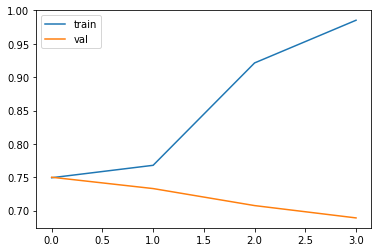

In [6]:
import matplotlib.pyplot as plt
# Plot performance by epoch
plt.plot(model_info.epoch,model_info.history['accuracy'])
plt.plot(model_info.epoch,model_info.history['val_accuracy'])
plt.legend(['train', 'val'], loc='best')

## Autoencoders

In [ ]:
from keras import backend as K

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

##TODO build a simple autoencoder with two compression layers and two econstruction layers using ReLu
##TODO compile and fit the model minimizing "mean_squared_error"
##report r_squared during training (the function r2 defined above)


In [ ]:
import keras

##TODO compress the vectorized text (X.todense())